In [48]:
import pandas as pd
from scipy.stats import skew
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline

## Reading the ratings data

In [21]:
ratings = pd.read_csv('.surprise_data\\ml-100k\\ml-100k\\u.data', sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings['timestamp_converted'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings.sort_values(by=['user_id', 'timestamp'], inplace=True)
ratings['seconds_since_previous_rating'] = ratings['timestamp'] - ratings.groupby(['user_id'])['timestamp'].shift(1)
ratings.drop(columns=['timestamp'], inplace=True)
ratings.head()

,user_id,item_id,rating,timestamp_converted,seconds_since_previous_rating
59972,1,168,5,1997-09-22 21:57:58,NaN
92487,1,172,5,1997-09-22 21:57:58,0.0
74577,1,165,5,1997-09-22 21:58:38,40.0
48214,1,156,4,1997-09-22 21:59:16,38.0
15764,1,196,5,1997-09-22 22:01:17,121.0


### Creating user based features for the anomaly detection model

In [89]:
ratings_by_user = ratings.groupby('user_id').agg(
    rating_count = ('rating', 'count'),
    min_seconds_since_previous_rating = ('seconds_since_previous_rating', 'min'),
    avg_seconds_since_previous_rating = ('seconds_since_previous_rating', 'mean'),
    avg_rating = ('rating', 'mean'), max_rating = ('rating', 'max'), min_rating = ('rating', 'min'),
    std_rating=('rating', 'std'), skew_rating=('rating', skew),
    percent_extremes=('rating', lambda x: ((x == 1.0).sum() + (x == 5.0).sum()) / len(x)))

ratings_by_user.reset_index(inplace=True)
ratings_by_user.head()

,user_id,rating_count,min_seconds_since_previous_rating,avg_seconds_since_previous_rating,avg_rating,max_rating,min_rating,std_rating,skew_rating,percent_extremes
0,1,272,0.0,54561.837638,3.610294,5,1,1.263585,-0.645064,0.389706
1,2,62,0.0,7053.770492,3.709677,5,1,1.030472,-0.937456,0.274194
2,3,54,0.0,10.245283,2.796296,5,1,1.219026,0.269008,0.259259
3,4,24,0.0,136.782609,4.333333,5,2,0.916831,-1.050139,0.583333
4,5,175,0.0,20481.804598,2.874286,5,1,1.362963,0.009682,0.388571


# Anomaly Detection Model

Using Isolation Forest 

In [90]:
from sklearn.impute import SimpleImputer
import numpy as np

pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('imp', SimpleImputer(missing_values=np.nan, strategy='mean')), 
    ('isolation_forest', IsolationForest(contamination=0.01, random_state=42))
])

#dropping user_id from the data
X = ratings_by_user.drop(columns='user_id')

predictions = pipe.fit_predict(X)

ratings_by_user['anomaly_score'] = predictions
ratings_by_user['is_anomaly'] = ratings_by_user['anomaly_score'] == -1
ratings_by_user.head()

,user_id,rating_count,min_seconds_since_previous_rating,avg_seconds_since_previous_rating,avg_rating,max_rating,min_rating,std_rating,skew_rating,percent_extremes,anomaly_score,is_anomaly
0,1,272,0.0,54561.837638,3.610294,5,1,1.263585,-0.645064,0.389706,1,False
1,2,62,0.0,7053.770492,3.709677,5,1,1.030472,-0.937456,0.274194,1,False
2,3,54,0.0,10.245283,2.796296,5,1,1.219026,0.269008,0.259259,1,False
3,4,24,0.0,136.782609,4.333333,5,2,0.916831,-1.050139,0.583333,1,False
4,5,175,0.0,20481.804598,2.874286,5,1,1.362963,0.009682,0.388571,1,False


### Plotting the flagged anomalies against average rating and number of ratings

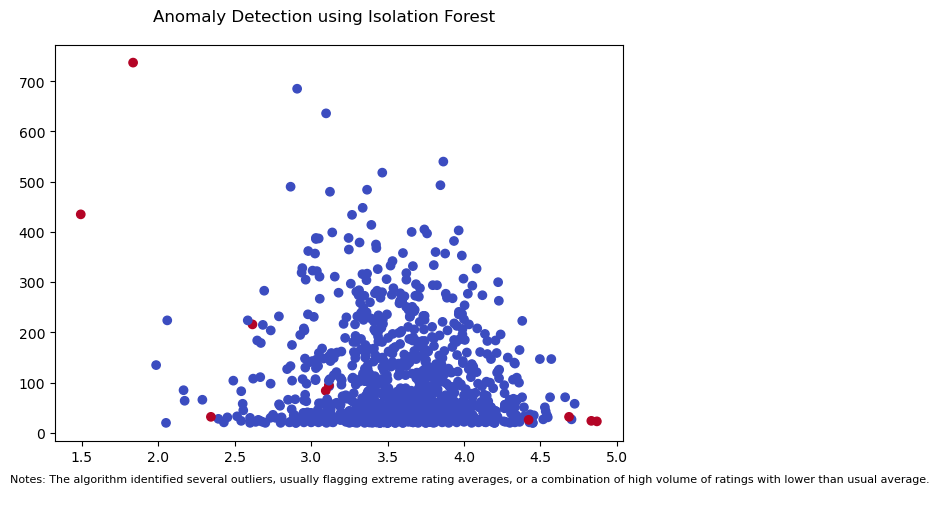

In [93]:
fig, axs = plt.subplots(1, 1, tight_layout=True) 

fig.suptitle('Anomaly Detection using Isolation Forest')
axs.scatter(ratings_by_user['avg_rating'], ratings_by_user['rating_count'], c=ratings_by_user['is_anomaly'], cmap='coolwarm')
plt.figtext(0.01, -0.03, "Notes: The algorithm identified several outliers, usually flagging extreme rating averages, or a combination of high volume of ratings with lower than usual average. \n", ha="left", fontsize=8)

plt.show()


### Inspection the flagged anomalies

In [92]:
ratings_by_user[ratings_by_user['is_anomaly']==1].sort_values(by='rating_count', ascending=False).head(20)

,user_id,rating_count,min_seconds_since_previous_rating,avg_seconds_since_previous_rating,avg_rating,max_rating,min_rating,std_rating,skew_rating,percent_extremes,anomaly_score,is_anomaly
404,405,737,0.0,7.211957,1.834464,5,1,1.345183,1.375591,0.750339,-1,True
180,181,435,0.0,5.225806,1.491954,5,1,0.846138,1.773061,0.689655,-1,True
101,102,216,0.0,79570.874419,2.615741,4,1,0.744301,0.006317,0.050926,-1,True
274,275,95,0.0,54909.553191,3.115789,4,2,0.598991,-0.042942,0.000000,-1,True
551,552,84,0.0,26.493976,3.095238,4,2,0.551429,0.051797,0.000000,-1,True
625,626,32,0.0,290376.774194,2.343750,5,1,1.536846,0.543488,0.625000,-1,True
927,928,32,0.0,49.032258,4.687500,5,3,0.692704,-1.881158,0.812500,-1,True
809,810,26,0.0,479140.240000,4.423077,5,3,0.702742,-0.780361,0.538462,-1,True
687,688,24,0.0,14.173913,4.833333,5,2,0.637022,-3.989829,0.916667,-1,True
848,849,23,0.0,45.590909,4.869565,5,4,0.344350,-2.194691,0.869565,-1,True


The users 405 and 181 seems to be consistently giving low ratings, and a lot of them in a short period of time, averaging under 10s between ratings.

The percent of extremes feature seems to be the strong indicator for the anomalies.

Users 102, 275 and 552 could have been flagged because they never rate 5s, even though they have a significant number of reviews, so they could be very picky users

In [87]:
ratings_by_user[ratings_by_user['max_rating']<5].sort_values(by='rating_count', ascending=False).head(10)

,user_id,rating_count,min_seconds_since_previous_rating,avg_seconds_since_previous_rating,avg_rating,max_rating,min_rating,std_rating,skew_rating,percent_extremes,anomaly_score,is_anomaly
101,102,216,0.0,79570.874419,2.615741,4,1,0.744301,0.006317,0.050926,-1,True
274,275,95,0.0,54909.553191,3.115789,4,2,0.598991,-0.042942,0.000000,-1,True
551,552,84,0.0,26.493976,3.095238,4,2,0.551429,0.051797,0.000000,-1,True
39,40,35,0.0,20.529412,2.885714,4,1,0.963188,-0.371789,0.085714,1,False
813,814,35,0.0,28.235294,2.971429,4,2,0.706512,0.038544,0.000000,1,False
563,564,34,0.0,382.515152,3.411765,4,2,0.656790,-0.646882,0.000000,1,False
749,750,33,0.0,16.125000,3.090909,4,1,1.041742,-0.856036,0.121212,1,False
854,855,23,0.0,10.545455,3.347826,4,2,0.647281,-0.443182,0.000000,1,False
204,205,22,0.0,24.428571,2.863636,4,1,1.037187,-0.511197,0.136364,1,False
301,302,21,0.0,14.800000,2.428571,4,1,0.870140,0.457082,0.095238,1,False
